# Problem  4
Consider the function:
$$Y(t; \lambda, \omega, \phi, y_0) := A \exp(- \lambda t) \cos(\omega t + \phi) + y_0$$
which represent a model for a time series with 5 parameters, where $A > 0$, $\lambda > 0$, $\omega > 0$, $\phi \in \mathbb{R}$, and $y_0 \in \mathbb{R}$.
Estimate, using the PSEO (Particle Swarm Optimization) algorithm, the value of $A$, $\lambda$, $\omega$, $\phi$, and $y_0$ that minimize the squared error:
$$ \mathcal{E}^2 (A, \lambda, \omega, \phi, y_0 ) := \sum_{i=1}^{n} [ y_i - Y(t_i; A, \lambda, \omega, \phi, y_0) ]^2 $$
where $(t_1, y_1),..., (t_n, y_n)$ are observed data according to the following table $n=5$ 

$$
\begin{array}{cc} \hline
t & y \\ \hline
1.0 & 2.443 \\
2.0 & -7.806 \\
3.0 & -2.909 \\
4.0 & 0.533 \\
5.0 & -7.304 \\
6.0 & -3.271 \\
7.0 & 0.0729 \\
8.0 & -5.609 \\
9.0 & -2.132 \\
10.0 & -1.930 \\ \hline
\end{array}
$$



In [464]:
import numpy as np
import matplotlib.pyplot as plt


In [465]:
t_obs = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
y_obs = np.array([2.443, -7.806, -2.909, 0.533, -7.304, -3.271, 0.0729, -5.609, -2.132, -1.930])


In [466]:
NDIMS = 5 # Number of dimensions (A, lambda, omega, phi, y0)
L = 15    # Search space limit
nparticles = 6000 # Number of particles
omega = 0.7   # Inertia weight
c1 = 1.4    # Cognitive coefficient
c2 = 1.4    # Social coefficient
tolerance = 1e-7  # Minimum improvement to consider "progress"
patience = 100    # How many iterations to wait if improvement < tolerance
feval = 0   # Function evaluations counter

In [467]:
def f(x):
    """
    X[0] = A      (Amplitud) -> Debe ser > 0
    X[1] = lam    (Lambda)   -> Debe ser > 0
    X[2] = omega  (Omega)    -> Debe ser > 0
    X[3] = phi    (Fase)     -> Real (sin restricción)
    X[4] = y0     (Offset)   -> Real (sin restricción)
    """
    global feval
    feval +=1
    if x[0] <= 0 or x[1] <= 0 or x[2] <= 0:
        return 1e10  # Penalize invalid parameters
        
    y_model = x[0] * np.exp(-x[1] *t_obs) * np.cos(x[2] * t_obs + x[3]) + x[4] #numerical model
    return np.sum((y_obs - y_model)**2)
    

In [468]:
#Inizalization
pos = np.random.uniform(-L, L, (nparticles, NDIMS)) # Particle positions
vel = np.zeros((nparticles, NDIMS)) # Particle velocities

In [469]:
#initial personal best positions and values
xbest = pos.copy()
fitness_current = np.apply_along_axis(f, 1, pos) # Current fitness
fitness_pbest = fitness_current.copy() # Personal best fitness


In [470]:
best_idx = np.argmin(fitness_pbest) # Global best index
xg = xbest[best_idx].copy() # Global best position
fbest = fitness_pbest[best_idx] # Global best fitness
print(f"Inicio: Evals={feval}, Error={fbest:.5}")
stuck = 0
fbest_old = fbest
history =[]

Inicio: Evals=6000, Error=94.054


In [471]:
while True:
    # 1. Update Velocity & Position
    r1 = np.random.rand(nparticles, 1)
    r2 = np.random.rand(nparticles, 1)
    
    vel = omega * vel + c1 * r1 * (xbest - pos) + c2 * r2 * (xg - pos) 
    
    # avoids explosion
    vel = np.clip(vel, -4.0, 4.0)
    
    pos = pos + vel 
    
    #  Limits  (Reflection)
    limit_high = pos > L
    limit_low = pos < -L
    
    pos[limit_high] = 2*L - pos[limit_high]
    pos[limit_low]  = -2*L - pos[limit_low]
    
    vel[limit_high] *= -0.5 
    vel[limit_low]  *= -0.5 
    
    #  Evaluation
    fitness_current = np.apply_along_axis(f, 1, pos) 
    limit_improve = fitness_current < fitness_pbest 
    xbest[limit_improve] = pos[limit_improve] 
    fitness_pbest[limit_improve] = fitness_current[limit_improve] 
    
    # Update Global Best
    current_best_idx = np.argmin(fitness_pbest)
    current_min_value = fitness_pbest[current_best_idx]
    
    if current_min_value < fbest:
        fbest = current_min_value
        xg = xbest[current_best_idx].copy()
        stuck = 0 # Reset patience because we improved!
        print(f"Improvement: Error={fbest:.6f}")
    history.append(fbest)
  
    #CONVERGENCE LOGIC (With Tolerance & Patience)
  
    
    
    
    
    # Check stagnation
    if abs(fbest_old - fbest) < tolerance:
        stuck += 1
    else:
        stuck = 0 # Significant improvement, reset counter
    fbest_old = fbest # Update memory
    # Action trigger
    if stuck >= patience:
        
        # SUCCESS CASE: We are stuck, but the error is sufficiently low (< 2.0)
        # This means we reached the mathematical limit (1.53...)
        if fbest < 2.0:
            print("\n" + "="*40)
            print("FINAL CONVERGENCE REACHED")
            print("="*40)
            print(f"Parameters n=5:")
            print(f"A = {xg[0]:.6}, lambda = {xg[1]:.6}, omega = {xg[2]:.6}, phi = {xg[3]:.6}, y0 = {xg[4]:.6}")
            print(f"Final Error = {fbest:.6f}")
            break # EXIT LOOP
            
        # FAILURE CASE: We are stuck in a bad local minimum (e.g., Error > 2.0)
        else:
            print(f"--- RESET (Stuck at bad local min: {fbest:.4f}) ---")
            
            # Re-initialize particles
            pos = np.random.uniform(-L, L, (nparticles, NDIMS))
            pos[:, 0:3] = np.abs(pos[:, 0:3])
            vel = np.zeros((nparticles, NDIMS))
            fitness_current = np.apply_along_axis(f, 1, pos)
            xbest = pos.copy()
            fitness_pbest = fitness_current.copy()
            
            # Reset Global Leader
            best_idx = np.argmin(fitness_pbest)
            xg = xbest[best_idx].copy()
            fbest = fitness_pbest[best_idx]
            
            stuck = 0

Improvement: Error=66.062697
Improvement: Error=33.892090
Improvement: Error=17.952098
Improvement: Error=14.809712
Improvement: Error=10.268714
Improvement: Error=3.748514
Improvement: Error=3.727576
Improvement: Error=3.106570
Improvement: Error=2.403533
Improvement: Error=1.944858
Improvement: Error=1.860961
Improvement: Error=1.859144
Improvement: Error=1.851635
Improvement: Error=1.834043
Improvement: Error=1.793514
Improvement: Error=1.772240
Improvement: Error=1.748353
Improvement: Error=1.714861
Improvement: Error=1.709192
Improvement: Error=1.693377
Improvement: Error=1.650095
Improvement: Error=1.618680
Improvement: Error=1.571207
Improvement: Error=1.550477
Improvement: Error=1.547221
Improvement: Error=1.540158
Improvement: Error=1.536638
Improvement: Error=1.535286
Improvement: Error=1.534221
Improvement: Error=1.533465
Improvement: Error=1.532950
Improvement: Error=1.532850
Improvement: Error=1.532755
Improvement: Error=1.532700
Improvement: Error=1.532696
Improvement: Er

In [472]:
t_continuous = np.linspace(0, 11, 200)
y_continuous= xg[0] * np.exp(-xg[1] * t_obs) * np.cos(xg[2] * t_obs + xg[3]) + xg[4]
error_rms = np.sqrt(np.mean((y_obs - y_continuous)**2))

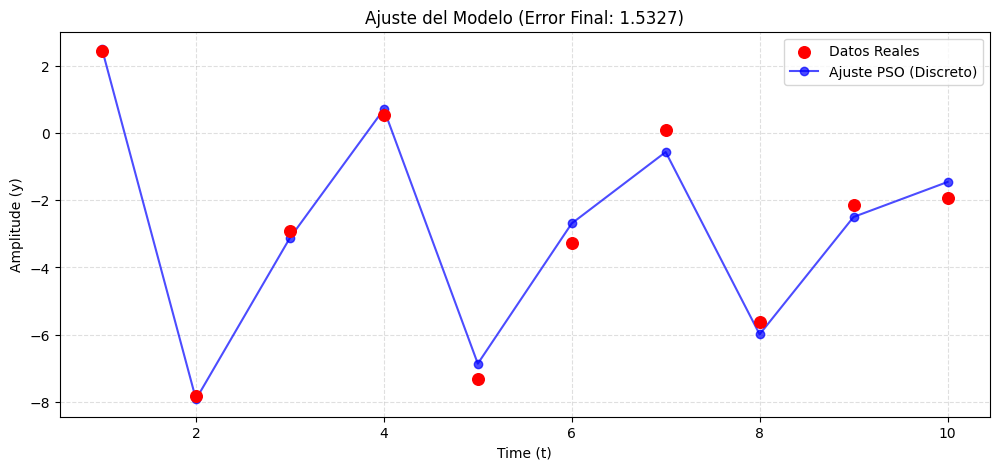

In [473]:
plt.figure(figsize=(12, 5))

plt.scatter(t_obs, y_obs, color='red', s=70, label='Datos Reales', zorder=3)
plt.plot(t_obs, y_continuous, 'bo-', linewidth=1.5, label='Ajuste PSO (Discreto)', alpha=0.7)

plt.title(f'Ajuste del Modelo (Error Final: {fbest:.4f})')
plt.xlabel('Time (t)')
plt.ylabel('Amplitude (y)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

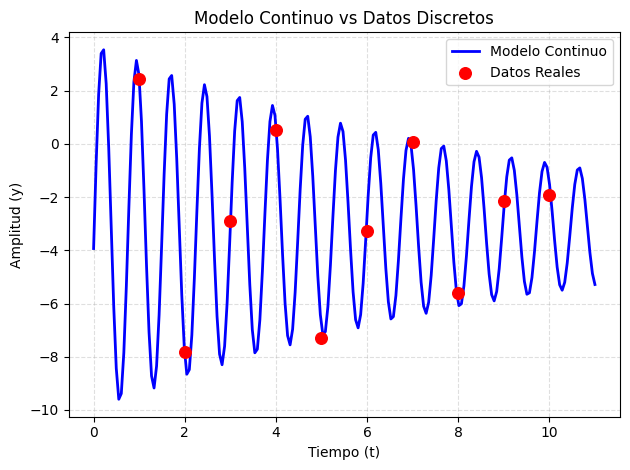

In [463]:
t_continuous = np.linspace(0, 11, 200)
y_continuous= xg[0] * np.exp(-xg[1] * t_continuous) * np.cos(xg[2] *t_continuous + xg[3]) + xg[4]
plt.plot(t_continuous, y_continuous, 'b-', linewidth=2, label='Modelo Continuo')
plt.scatter(t_obs, y_obs, color='red', s=70, label='Datos Reales', zorder=3)
plt.xlabel('Tiempo (t)')
plt.ylabel('Amplitud (y)')
plt.title('Modelo Continuo vs Datos Discretos')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()    